# Computing Zonal Statistics with ASTER Thermal Infrared GeoTIFFs

AST_L1T: [ASTER Level 1 Precision Terrain Corrected Registered At-Sensor Radiance](https://lpdaac.usgs.gov/products/ast_l1tv003/)

### AST_L1T GeoTIFFs

The TIR AST_L1T GeoTIFFs: 
* B14 (Red), B12 (Green), B10 (Blue)
* 90 m/px
* Degrees Kelvin scaled from 16-bit to 8-bit ????

### Radiometry:

AST_L1T TIR data are scaled to digital number values for the TIR bands as follows:
* DN of 0 corresponds to "no data"
* DN of 1 corresponds to a radiance of 0 $W m^{-2} sr^{-1} \mu m^{-1}$
* DN of 4094 is the maximum radiance for TIR bands
* DN of 4095 is the value for saturated pixels in TIR bands

At-Sensor Radiance (L) is calculated from DNs using the Unit Conversion Coefficients $[W m^{-2} sr^{-1} \mu m^{-1} / DN]$ :

<div style="font-size: 130%;", align="center">
$L_s = (DN - 1) \times ucc$
</div>

Brightness temperature is calculated from radiances (L) using the constants K1 $[W m^{-2} sr^{-1} \mu m^{-1}]$ and K2 $[K]$ in the Planck formula:

<div style="font-size: 170%;", align="center">
$T_b = \frac{K_2}{ln (\frac{K_1}{L_s} + 1)}$
</div>

| Band | Wavelength ($\mu m$)| ucc          | K1      | K2      |
| ---  | ---                 | ---          | ---     | ---     |
| 10   | 8.125–8.475         | 6.822 x 10-3 | 3047.47 | 1736.18 |
| 11   | 8.475–8.825         | 6.780 x 10-3 | 2480.93 | 1666.21 |
| 12   | 8.925–9.275         | 6.590 x 10-3 | 1930.80 | 1584.72 |
| 13   | 10.250–10.950       | 5.693 x 10-3 | 865.65  | 1349.82 |
| 14   | 10.950–11.650       | 5.225 x 10-3 | 649.60  | 1274.49 |



---
See also: *Jiménez-Muñoz, J. C., & Sobrino, J. A. (2009). A single-channel algorithm for land-surface temperature retrieval from ASTER data. IEEE Geoscience and Remote Sensing Letters, 7(1), 176-179.*

*Portions of this notebook were derived from [this example with Sentinel satellite imagery](https://github.com/shakasom/zonalstatistics/).*

---
To do:
- fix nodata issue in masking (you can see all the zeros I end up with in this histograms, which I want to convert to nan values so that I can ignore them)

---

In [338]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.mask import mask
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#https://pypi.org/project/matplotlib-scalebar/
#ax.add_artist(Scalebar(res)) where res is the pixel resolution in meters
#If already set imshow(extent=extent) parameter, use res=1.0

In [3]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

---

### Open an ASTER TIR image

In [334]:
# inspect metadata with gdal
#!gdalinfo "\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_band14_Tuolumne-and-CUES\AST_L1T_00311262018060119_20181128034140_15697_ImageData14.tif"

In [167]:
#src = rio.open(r"\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_Tuolumne-and-CUES\T_both\AST_L1T_00311262018060119_20181128034140_15697_T.tif")
src = rio.open(r"\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_band14_Tuolumne-and-CUES\AST_L1T_00311262018060119_20181128034140_15697_ImageData14.tif")
# src.meta
# src.count, src.width, src.height

### Unit conversions
Convert DN to radiance, then radiance to brightness temperature

In [236]:
# Read the first (and only) band
aster_b14_DN = src.read(1)

# change data type to float64 so we can fill in DN=0 with NaN values
aster_b14_DN = aster_b14_DN.astype('float64')
aster_b14_DN[aster_b14_DN==0] = np.nan

# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
aster_b14_rad = tir_dn2rad(aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature
aster_b14_tb = tir_rad2tb(aster_b14_rad, band_number)

### Open a shapefile
(these will be the GOES pixel footprints)

In [240]:
testshape = gpd.read_file(r"C:\Users\steve\Desktop\test1.shp")
testshape.head()

,id,geometry
0,0,"POLYGON ((-119.31453 37.86398, -119.30652 37.9..."


Make sure our shapefile is the same CRS as the ASTER TIR image

In [241]:
print('ASTER CRS: {}'.format(src.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: +init=epsg:32611
Shapefile CRS: {'init': 'epsg:4326'}


In [242]:
testshape = testshape.to_crs(src.crs)

In [243]:
print('ASTER CRS: {}'.format(src.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: +init=epsg:32611
Shapefile CRS: +init=epsg:32611


---
### Plot the shapefile on top of the ASTER image to see where we are

**TO DO** 
* add subplot zoomed in on area outlined by shapefile
* add scalebars to plot and subplot
* add colorbar for brightness temperature values
* format title, axes, labels, legend
* add histogram plots for main plot and subplot area

### Mask the ASTER TIR image to the area of the shapefile

In [296]:
masked_aster_b14_DN, mask_transform = mask(dataset=src, 
                                           shapes=testshape.geometry,
                                           crop=True,
                                           all_touched=True,
                                           filled=True)

# We still have a "bands" axis even though there's only one band, we can remove it below
masked_aster_b14_DN.shape

(1, 57, 61)

In [291]:
# change data type to float64 so we can fill in DN=0 with NaN values
masked_aster_b14_DN = masked_aster_b14_DN.astype('float64')
masked_aster_b14_DN[masked_aster_b14_DN==0] = np.nan

# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
masked_aster_b14_rad = tir_dn2rad(masked_aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature
masked_aster_b14_tb = tir_rad2tb(masked_aster_b14_rad, band_number)

# Remove the extra dimension (bands, we only have one band here)
masked_aster_b14_tb = masked_aster_b14_tb.squeeze()

### Calculate zonal statistics for this area
(mean, max, min, std:)

In [387]:
# Compute zonal statistics
# Remove NaN pixel values
values = masked_aster_b14_tb.flatten()
values = values[~np.isnan(values)]

masked_aster_b14_tb_mean = values.mean()
masked_aster_b14_tb_max = values.max()
masked_aster_b14_tb_min = values.min()
masked_aster_b14_tb_std = values.std()

# Print zonal statistics
print('Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(masked_aster_b14_tb_mean,
                                                   masked_aster_b14_tb_max,
                                                   masked_aster_b14_tb_min,
                                                   masked_aster_b14_tb_std))

Mean: 266.3508478048053
Max: 270.35546000246893
Min: 258.0571122149908
Std: 1.9324627128947458


### Plots

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


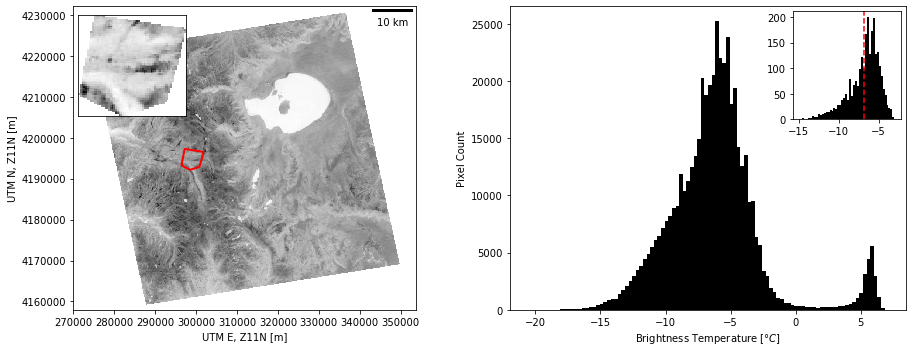

In [386]:
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(15, 5), 
                       gridspec_kw={'width_ratios': [2, 1]}, 
                       tight_layout=True)

# plot ASTER image
rioplt.show(aster_b14_tb, transform=src.transform, ax=ax[0], cmap='Greys_r')
ax[0].set_ylabel('UTM N, Z11N [m]')
ax[0].set_xlabel('UTM E, Z11N [m]')
# Add scalebar
scalebar = ScaleBar(1, length_fraction=0.15) # get image resolution from original raster image (1 pixel = X meters)
ax[0].add_artist(scalebar) 

# Plot shapefile outline
testshape.plot(ax=ax[0], color="none", ec='red', linewidth=2, linestyle='-', alpha=1)


# Plot ASTER image cropped to shapefile
aster_inset_ax = inset_axes(ax[0],
                    width=1.5, # width : 1 inch
                    height=1.5, # height : 1 inch
                    loc=2)
image_data = masked_aster_b14_tb
rio.plot.show(image_data,
              ax=aster_inset_ax,
              cmap='Greys_r')
#scalebar = ScaleBar(src.res[0]) # get image resolution from original raster image
#aster_inset_ax.add_artist(scalebar)
aster_inset_ax.tick_params(axis='both', bottom=False, top=False, left=False, right=False)
aster_inset_ax.xaxis.set_ticklabels([])
aster_inset_ax.yaxis.set_ticklabels([])


# Plot a histogram
tb_c = aster_b14_tb.flatten() - 273.15 # convert from brightness temp in K to C, and flatten to a 1-D array
ax[1].hist(tb_c, bins=100, facecolor='k');
ax[1].set_ylabel('Pixel Count')
ax[1].set_xlabel('Brightness Temperature [$\degree C$]')

# Plot histogram for area within shapefile
hist_inset_ax = inset_axes(ax[1],
                    width=1.5, # width : 1 inch
                    height=1.5, # height : 1 inch
                    loc=1)
hist_inset_ax.hist(values-273.15, bins=50, facecolor='k');
hist_inset_ax.axvline(x=masked_aster_b14_tb_mean-273.15, c='r', linestyle='--')

plt.show();

